# Divvy Bike Usage Analysis

## Imports and Set-Up

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ipython-sql
!pip install pandas
!pip install pandasql
!pip install geopy


In [3]:
%cd /content/drive/MyDrive/DivvyBike/

/content/drive/MyDrive/DivvyBike


In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial import distance

import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import folium
from folium.plugins import HeatMap

###Define the Binning Function

In [5]:
def filter_and_bin_data(ride_data_file, station_data_file, output_file, bins=100000):
    # Read the Divvy Bike stations data
    df_stations = pd.read_csv(station_data_file)

    # Create a HashMap of station coordinates and names
    station_map = dict(zip(zip(df_stations['Latitude'], df_stations['Longitude']), df_stations['Station Name']))

    # Load the combined bike rides data in chunks
    chunk_size = 100000
    ride_chunks = pd.read_csv(ride_data_file, chunksize=chunk_size)

    # Prepare a list to store filtered data
    filtered_data = []

    # Iterate over the ride chunks
    for df_chunk in ride_chunks:
        # Filter rides that don't start or end at Divvy bike stations
        df_filtered = df_chunk[(df_chunk['start_station_id'].isna() | df_chunk['end_station_id'].isna())]

        # Filter out rows with missing or invalid coordinates
        df_filtered = df_filtered.dropna(subset=['start_lat', 'start_lng'])

        # Convert coordinates to float
        df_filtered['start_lat'] = df_filtered['start_lat'].astype(float)
        df_filtered['start_lng'] = df_filtered['start_lng'].astype(float)

        # Calculate distances using the HashMap
        ride_start_points = df_filtered[['start_lat', 'start_lng']].values
        nearest_station_coords = list(station_map.keys())
        distances = distance.cdist(ride_start_points, nearest_station_coords, metric='cityblock')
        nearest_station_indices = distances.argmin(axis=1)
        nearest_station_names = [station_map[nearest_station_coords[i]] for i in nearest_station_indices]

        # Add the filtered data to the list
        df_filtered['nearest_station_distance'] = distances.min(axis=1)
        df_filtered['nearest_station_name'] = nearest_station_names
        filtered_data.append(df_filtered)

    # Concatenate all filtered data into a single DataFrame
    df_filtered = pd.concat(filtered_data)

    # Select the required columns
    columns_to_keep = ['nearest_station_distance', 'nearest_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng']
    df_filtered = df_filtered[columns_to_keep]

    # Save the filtered data to a new file
    df_filtered.to_csv(output_file, index=False)

    # Preparation Stage
    start = time.time()

    # Define the values to bin
    values = df_filtered['nearest_station_distance'].values

    # Calculate bin intervals
    values_min = values.min()
    values_max = values.max()
    values_range = values_max - values_min
    interval_range = values_range / bins

    bin_intervals = {b: (values_min + b * interval_range, values_min + (b + 1) * interval_range) for b in range(bins)}

    # Fill up bins with indices of values
    bin_idx_dict = {}
    for b, interval in tqdm(bin_intervals.items()):
        low = interval[0]
        high = interval[1]
        bin_idx_dict[b] = np.where((values >= low) & (values < high))[0].flatten()

    end = time.time()
    print(end - start)

    # Implementation
    start = time.time()

    # Define the value to bin mapping function
    val_to_bin_idx = lambda x: int((x - values_min) / interval_range)

    # Define the value for which to find the nearest neighbors
    val_match = values.max() if output_file.endswith('farthest_divvy_location.csv') else values.min()

    # Handle the case where the maximum/minimum bin index exceeds the valid range
    if val_match == values_max:
        neighbor_bin_idx_center = bins - 1
    else:
        neighbor_bin_idx_center = val_to_bin_idx(val_match)

    neighbor_center_idx = bin_idx_dict[neighbor_bin_idx_center]
    neighbor_center = values[neighbor_center_idx]

    neighbor_left = None
    neighbor_bin_idx_left = neighbor_bin_idx_center
    while neighbor_left is None:
        neighbor_bin_idx_left -= 1
        try:
            neighbor_left_idx = bin_idx_dict[neighbor_bin_idx_left]
            if neighbor_left_idx.shape[0] > 0:
                neighbor_left = values[neighbor_left_idx]
        except KeyError:
            neighbor_left_idx = np.array([])
            neighbor_left = np.array([])

    neighbor_right = None
    neighbor_bin_idx_right = neighbor_bin_idx_center
    while neighbor_right is None:
        neighbor_bin_idx_right += 1
        try:
            neighbor_right_idx = bin_idx_dict[neighbor_bin_idx_right]
            if neighbor_right_idx.shape[0] > 0:
                neighbor_right = values[neighbor_right_idx]
        except KeyError:
            neighbor_right_idx = np.array([])
            neighbor_right = np.array([])

    neighbor_idx = np.concatenate([neighbor_left_idx, neighbor_center_idx, neighbor_right_idx]).astype(int)
    neighbors = np.concatenate([neighbor_left, neighbor_center, neighbor_right])

    dist1d = np.abs(neighbors - val_match)
    extreme_dist = dist1d.max() if output_file.endswith('farthest_divvy_location.csv') else dist1d.min()
    idx = np.where(dist1d == extreme_dist)[0]
    print(val_match)
    print(neighbor_idx[idx], values[neighbor_idx[idx]])

    end = time.time()
    print(end - start)


## Data Preparation
Combine Divvy bike datasets from different time periods together.

In [6]:
# List of file names
file_names = [
    '202304-divvy-tripdata.csv',
    '202303-divvy-tripdata.csv',
    '202302-divvy-tripdata.csv',
    '202301-divvy-tripdata.csv',
    '202212-divvy-tripdata.csv',
    '202211-divvy-tripdata.csv',
    '202210-divvy-tripdata.csv',
    '202209-divvy-publictripdata.csv',
    '202208-divvy-tripdata.csv',
    '202207-divvy-tripdata.csv',
    '202206-divvy-tripdata.csv',
    '202205-divvy-tripdata.csv'
]

# Specify the file path for the output CSV file
output_file_path = 'combined_divvy_rides.csv'

# Define the column names
column_names = ['ride_id', 'rideable_type', 'started_at', 'ended_at',
                'start_station_name', 'start_station_id', 'end_station_name',
                'end_station_id', 'start_lat', 'start_lng', 'end_lat',
                'end_lng', 'member_casual']

# Chunk size for processing
chunk_size = 100000

# Initialize an empty DataFrame for storing the combined data
df_combined = pd.DataFrame()

# Process each file in chunks and append to the combined DataFrame
for i, file_name in enumerate(file_names):
    file_path = file_name

    # Read the file in chunks
    for chunk in pd.read_csv(file_path, header=None, chunksize=chunk_size, engine='python'):
        df_combined = pd.concat([df_combined, chunk])

# Save the combined DataFrame to the output CSV file without column names
df_combined.to_csv(output_file_path, index=False, header=False)

## Data Load-In

In [7]:
# Read the CSV file with specified data types or low_memory=False
df_combined = pd.read_csv('combined_divvy_rides.csv', low_memory=False)

# Print the first row
df_combined.head(1)


ride_id  rideable_type           started_at             ended_at  \
0  8FE8F7D9C10E88C7  electric_bike  2023-04-02 08:37:28  2023-04-02 08:41:37   

  start_station_name start_station_id end_station_name end_station_id  \
0                NaN              NaN              NaN            NaN   

  start_lat start_lng end_lat end_lng member_casual  
0      41.8     -87.6   41.79   -87.6        member

## Analysis

### Ride Start/End Distribution
Many Divvy bike rides are started but not ended (the Divvy bike is abandoned), ended but not started (an abandoned Divvy bike is returned) or neither (an abandoned bike is found, ridden, and then abandoned). Most are started and ended. The below plot shows the distribution.

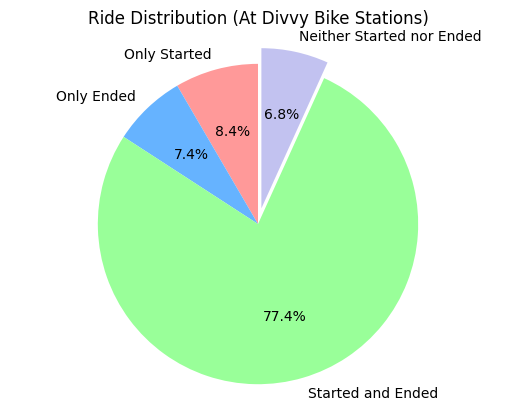

In [8]:
# Read the combined CSV file
# Filter rows where rides only started at a station
started_only_count = df_combined[df_combined['end_station_id'].isna() & df_combined['start_station_id'].notna()].shape[0]

# Filter rows where rides only ended at a station
ended_only_count = df_combined[df_combined['start_station_id'].isna() & df_combined['end_station_id'].notna()].shape[0]

# Filter rows where rides both started and ended at a station
started_and_ended_count = df_combined[df_combined['start_station_id'].notna() & df_combined['end_station_id'].notna()].shape[0]

# Calculate the total number of rides
total_rides = len(df_combined)

# Calculate the percentages
started_only_percentage = (started_only_count / total_rides) * 100
ended_only_percentage = (ended_only_count / total_rides) * 100
started_and_ended_percentage = (started_and_ended_count / total_rides) * 100
neither_started_nor_ended_percentage = 100 - started_only_percentage - ended_only_percentage - started_and_ended_percentage

# Create a pie chart
labels = ['Only Started', 'Only Ended', 'Started and Ended', 'Neither Started nor Ended']
sizes = [started_only_percentage, ended_only_percentage, started_and_ended_percentage, neither_started_nor_ended_percentage]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#c2c2f0']
explode = (0, 0, 0, 0.1)  # explode the last slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Ride Distribution (At Divvy Bike Stations)')
plt.show()


### Map of Top 200 Used Divvy Bike Stations

In [9]:
# Read the combined Divvy rides data
df_combined = pd.read_csv('combined_divvy_rides.csv')

# Group the data by start station coordinates and count the number of rides
station_counts = df_combined.groupby(['start_lat', 'start_lng', 'start_station_name']).size().reset_index(name='ride_count')

# Sort the stations by ride count in descending order
station_counts = station_counts.sort_values('ride_count', ascending=False)

# Take the top N stations with the highest ride count
top_n_stations = station_counts.head(200)

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the start station coordinates and ride count
heatmap_data = top_n_stations[['start_lat', 'start_lng', 'ride_count']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the top N stations and append data to CSV file
with open('divvy_stations_with_ride_count.csv', 'w') as f:
    f.write('Station,Lat,Lng,Ride Count\n')
    for idx, row in top_n_stations.iterrows():
        lat, lng = row['start_lat'], row['start_lng']
        ride_count = row['ride_count']
        station_name = row['start_station_name']
        f.write(f"{station_name},{lat},{lng},{ride_count}\n")
        folium.Marker(
            location=[lat, lng],
            popup=f"Station: {station_name}<br>Ride Count: {ride_count}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(map_divvy)

# Save the map as an HTML file
map_divvy.save('divvy_map.html')

# Display the map
map_divvy

<ipython-input-9-e602f8e2fe9a>:2: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv('combined_divvy_rides.csv')


###Divvy Bike Rides That Take Place Nearest to Stations without Starting or Ending at One

In [10]:
# Call the function for nearest divvy location binning
filter_and_bin_data('combined_divvy_rides.csv', 'Divvy_Bicycle_Stations_-_All_-_Map.csv', 'binned_nearest_divvy_location.csv', bins=100000)




<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_m

80.07868361473083
0.0
[  13051   13267   13346 ... 1320163 1321524 1325056] [0. 0. 0. ... 0. 0. 0.]
0.0032806396484375


In [11]:
# Read the filtered data with nearest Divvy bike locations
df_filtered = pd.read_csv('binned_nearest_divvy_location.csv')

# Group the data by nearest station coordinates and count the number of occurrences
station_counts = df_filtered.groupby(['start_lat', 'start_lng', 'nearest_station_name']).size().reset_index(name='count')

# Sort the stations by count in descending order
station_counts = station_counts.sort_values('count', ascending=False)

# Take the top N stations with the highest count
top_n_stations = station_counts.head(200)

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the start station coordinates and count
heatmap_data = top_n_stations[['start_lat', 'start_lng', 'count']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the top N stations and append data to CSV file
with open('binned_nearest_divvy_stations_with_count.csv', 'w') as f:
    f.write('Station,Lat,Lng,Count\n')
    for idx, row in top_n_stations.iterrows():
        lat, lng = row['start_lat'], row['start_lng']
        count = row['count']
        station_name = row['nearest_station_name']
        f.write(f"{station_name},{lat},{lng},{count}\n")
        folium.Marker(
            location=[lat, lng],
            popup=f"Station: {station_name}<br>Count: {count}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(map_divvy)

# Save the map as an HTML file
map_divvy.save('binned_nearest_divvy_map.html')

# Display the map
map_divvy




In [12]:
# Read the top 200 stations from the combined_divvy_rides.csv
df_combined = pd.read_csv('combined_divvy_rides.csv')
top_combined_stations = df_combined.groupby(['start_station_name']).size().nlargest(200).index.tolist()

# Read the top 200 stations from the binned_nearest_divvy_location.csv
df_binned = pd.read_csv('binned_nearest_divvy_location.csv')
top_binned_stations = df_binned.groupby(['nearest_station_name']).size().nlargest(200).index.tolist()

# Find the stations present in the binned CSV but not in the combined CSV
stations_only_in_binned = set(top_binned_stations) - set(top_combined_stations)

# Create a DataFrame for the stations only in the binned CSV
df_stations_only_in_binned = pd.DataFrame({'station_name': list(stations_only_in_binned)})

# Save the stations to a new CSV file
output_file_path = 'stations_only_in_binned.csv'
df_stations_only_in_binned.to_csv(output_file_path, index=False)

# Print the stations present in the binned CSV but not in the combined CSV
print("Stations present in binned CSV but not in combined CSV:")
for station in stations_only_in_binned:
    print(station)

print("Stations present in binned CSV but not in combined CSV saved to:", output_file_path)



<ipython-input-12-cc230aa6fa06>:2: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv('combined_divvy_rides.csv')


Stations present in binned CSV but not in combined CSV:
Chicago Ave & Washington St
Kimball Ave & Belmont Ave
Public Rack - Karlov Ave & Milwaukee Ave
Public Rack - Woodlawn Ave & 63rd St S
Francisco Ave & Montrose Ave
Public Rack - California Ave & Cortez St
Central Park Ave & North Ave
Lincoln Ave & Waveland Ave
Public Rack - Sacramento Blvd & Division St
Clark St & Lunt Ave
Public Rack - Division St & Christiana Ave
Milwaukee Ave & Rockwell St
Public Rack - Kenton Ave & Palmer St
Campbell Ave & Montrose Ave
Clark St & Elmdale Ave
Damen Ave & Charleston St
Wood St & Webster Ave
Public Rack - Laporte Ave & Armitage Ave
Noble St & Milwaukee Ave
Wentworth Ave & 24th St (Temp)
Troy St & Grace St
Sheridan Rd & Loyola Ave
Western Ave & Grace St
Morgan St & 18th St
Ping Tom Park (East)
Canal St & Taylor St
Greenwood Ave & 47th St
Kosciuszko Park
Indiana Ave & 31st St
Harper Ave & 59th St
Wood St & Taylor St (Temp)
Public Rack - Spaulding Ave & North Ave
Ashland Ave & Wrightwood Ave
Public R

<ipython-input-13-d23e2bcf604d>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gradient_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(stations)))


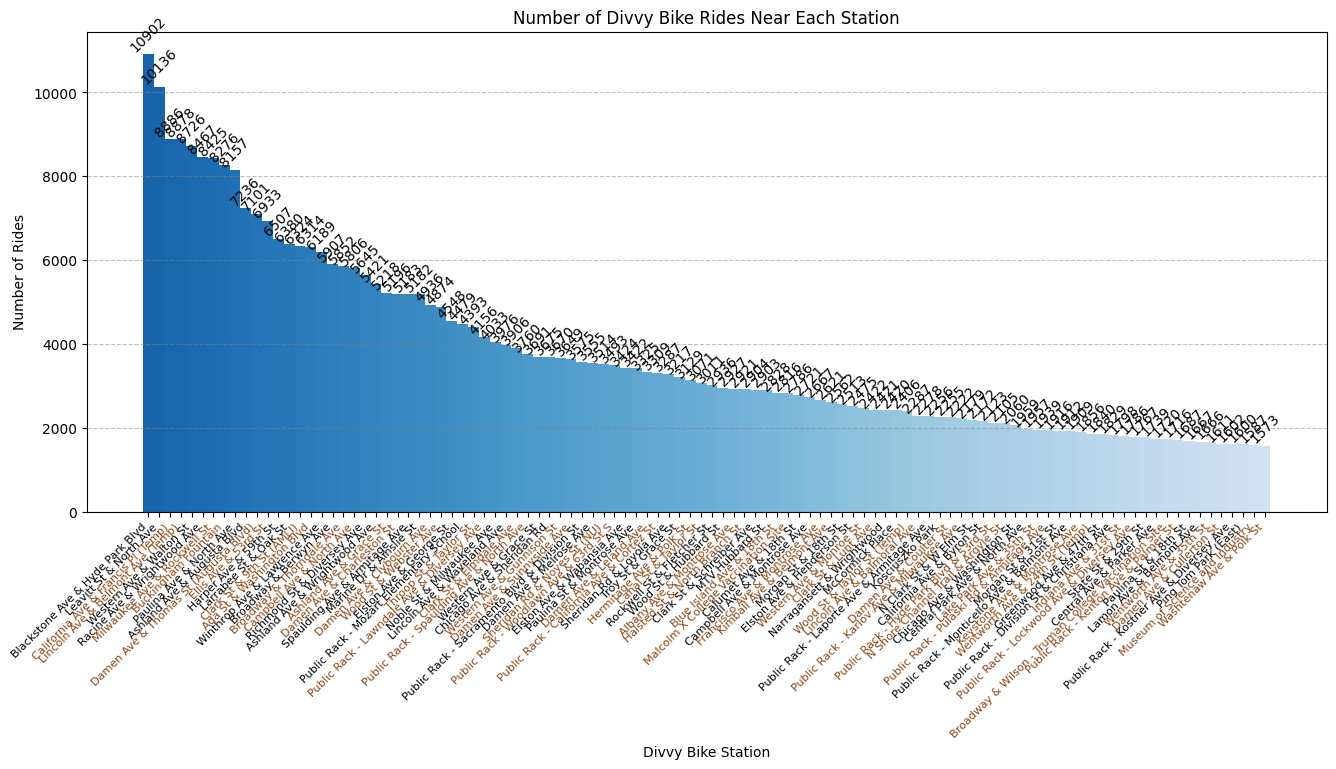

In [13]:
# Load the station data
stations_data = pd.read_csv('stations_only_in_binned.csv')
stations = stations_data['station_name'].tolist()

# Load the bike ride data
bike_ride_data = pd.read_csv('binned_nearest_divvy_location.csv')

# Count the number of rides near each station
rides_count = bike_ride_data['nearest_station_name'].value_counts().loc[stations]

# Sort the stations by the number of rides in descending order
rides_count_sorted = rides_count.sort_values(ascending=False)

# Adjust spacing parameters
bar_width = 1.0  # Adjust the bar width
spacing = 0  # Adjust the spacing between bars

fig, ax = plt.subplots(figsize=(16, 10))

# Calculate the total width for each station including spacing
total_width = bar_width * len(stations) + spacing * (len(stations) - 1)

# Calculate the starting position for each station
x = np.arange(len(stations)) * (bar_width + spacing)

# Reverse the order of gradient colors
gradient_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(stations)))

# Create the bar graph with reversed gradient colors
bars = ax.bar(x, rides_count_sorted, width=bar_width, align='edge', color=gradient_colors)

# Adjust the positioning and alignment of bar labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom', rotation=45)

# Add spacing between the station names
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(rides_count_sorted.index, rotation=45, ha='right', fontsize=8)

plt.subplots_adjust(bottom=0.4)

# Set colors for the station names and numbers
xtick_labels = ax.get_xticklabels()
for i, label in enumerate(xtick_labels):
    if i % 4 < 2:
        label.set_color('black')
    else:
        label.set_color('saddlebrown')

# Set colors for the grid lines
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(False)

# Set axis labels and title
ax.set_xlabel('Divvy Bike Station')
ax.set_ylabel('Number of Rides')
ax.set_title('Number of Divvy Bike Rides Near Each Station')

plt.show()






##Stations to Recommend More Bike Placements At
With people seeing the advertisements for Divvy bike as others ride on by, people are more inclined to want to join in or join friends who are riding already by picking up a bike at a station as a meet up point

<ipython-input-14-86be1a7eeffd>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gradient_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(top_stations)))


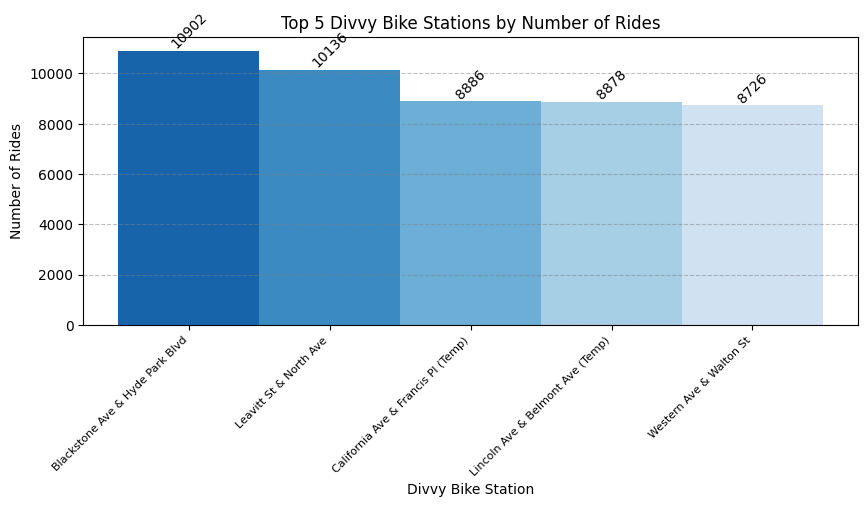

In [14]:
# Load the station data
stations_data = pd.read_csv('stations_only_in_binned.csv')
stations = stations_data['station_name'].tolist()

# Load the bike ride data
bike_ride_data = pd.read_csv('binned_nearest_divvy_location.csv')

# Count the number of rides near each station
rides_count = bike_ride_data['nearest_station_name'].value_counts().loc[stations]

# Sort the stations by the number of rides in descending order
rides_count_sorted = rides_count.sort_values(ascending=False)

# Select only the top 5 stations
top_stations = rides_count_sorted.head(5)

# Adjust spacing parameters
bar_width = 1.0  # Adjust the bar width
spacing = 0  # Adjust the spacing between bars

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the total width for each station including spacing
total_width = bar_width * len(top_stations) + spacing * (len(top_stations) - 1)

# Calculate the starting position for each station
x = np.arange(len(top_stations)) * (bar_width + spacing)

# Reverse the order of gradient colors
gradient_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(top_stations)))

# Create the bar graph with reversed gradient colors
bars = ax.bar(x, top_stations, width=bar_width, align='edge', color=gradient_colors)

# Adjust the positioning and alignment of bar labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom', rotation=45)

# Add spacing between the station names
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(top_stations.index, rotation=45, ha='right', fontsize=8)

plt.subplots_adjust(bottom=0.4)

# Set colors for the grid lines
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(False)

# Set axis labels and title
ax.set_xlabel('Divvy Bike Station')
ax.set_ylabel('Number of Rides')
ax.set_title('Top 5 Divvy Bike Stations by Number of Rides')

plt.show()



###Divvy Bike Rides That Have the Greatest Distance from Nearby Stations

In [15]:
# Call the function for the farthest Divvy location binning
filter_and_bin_data('combined_divvy_rides.csv', 'Divvy_Bicycle_Stations_-_All_-_Map.csv', 'binned_farthest_divvy_location.csv', bins=99999)




<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-5-0d814bdd701f>:16: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_m

80.24853515625
0.038181000000001575
[967506] [0.029557]
0.005670785903930664


In [16]:
# Read the filtered data with farthest Divvy bike ride locations
df_filtered = pd.read_csv('binned_farthest_divvy_location.csv')

# Group the data by start station coordinates and count the number of occurrences
station_counts = df_filtered.groupby(['end_lat', 'end_lng', 'nearest_station_name']).size().reset_index(name='count')

# Sort the stations by count in descending order
station_counts = station_counts.sort_values('count', ascending=False)

# Take the top N stations with the highest count
top_n_stations = station_counts.head(200)

# Save the count data to a CSV file
top_n_stations.to_csv('binned_farthest_station_counts.csv', index=False)

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the end station coordinates and count
heatmap_data = top_n_stations[['end_lat', 'end_lng', 'count']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the top N stations
for idx, row in top_n_stations.iterrows():
    lat, lng = row['end_lat'], row['end_lng']
    count = row['count']
    station_name = row['nearest_station_name']
    folium.Marker(
        location=[lat, lng],
        popup=f"Station: {station_name}<br>Count: {count}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_divvy)

# Get the maximum distance
max_distance = df_filtered['nearest_station_distance'].max()

# Add points for all the farthest Divvy bike ride locations
farthest_locations = df_filtered.loc[df_filtered['nearest_station_distance'] >= max_distance]
for idx, row in farthest_locations.iterrows():
    lat, lng = row['end_lat'], row['end_lng']
    color = 'red' if row['nearest_station_distance'] == max_distance else 'orange'
    folium.CircleMarker(
        location=[lat, lng],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
    ).add_to(map_divvy)

# Save the map as an HTML file
map_divvy.save('binned_farthest_divvy_map.html')

# Display the map
map_divvy





In [17]:
# Read the binned_farthest_divvy_location.csv file
df_farthest = pd.read_csv('binned_farthest_divvy_location.csv')

# Read the binned_nearest_divvy_location.csv file
df_nearest = pd.read_csv('binned_nearest_divvy_location.csv')

# Extract the unique station names from both dataframes
farthest_station_names = set(df_farthest['nearest_station_name'])
nearest_station_names = set(df_nearest['nearest_station_name'])

# Find the station names that are in farthest dataset but not in nearest dataset
station_names_not_in_nearest = farthest_station_names - nearest_station_names

# Create a dataframe with the station names
station_names_df = pd.DataFrame({'station_name': list(station_names_not_in_nearest)})

# Save the dataframe to a CSV file
station_names_df.to_csv('station_names_not_in_nearest.csv', index=False)



<ipython-input-18-7f079b556ea6>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(sorted_stations)))


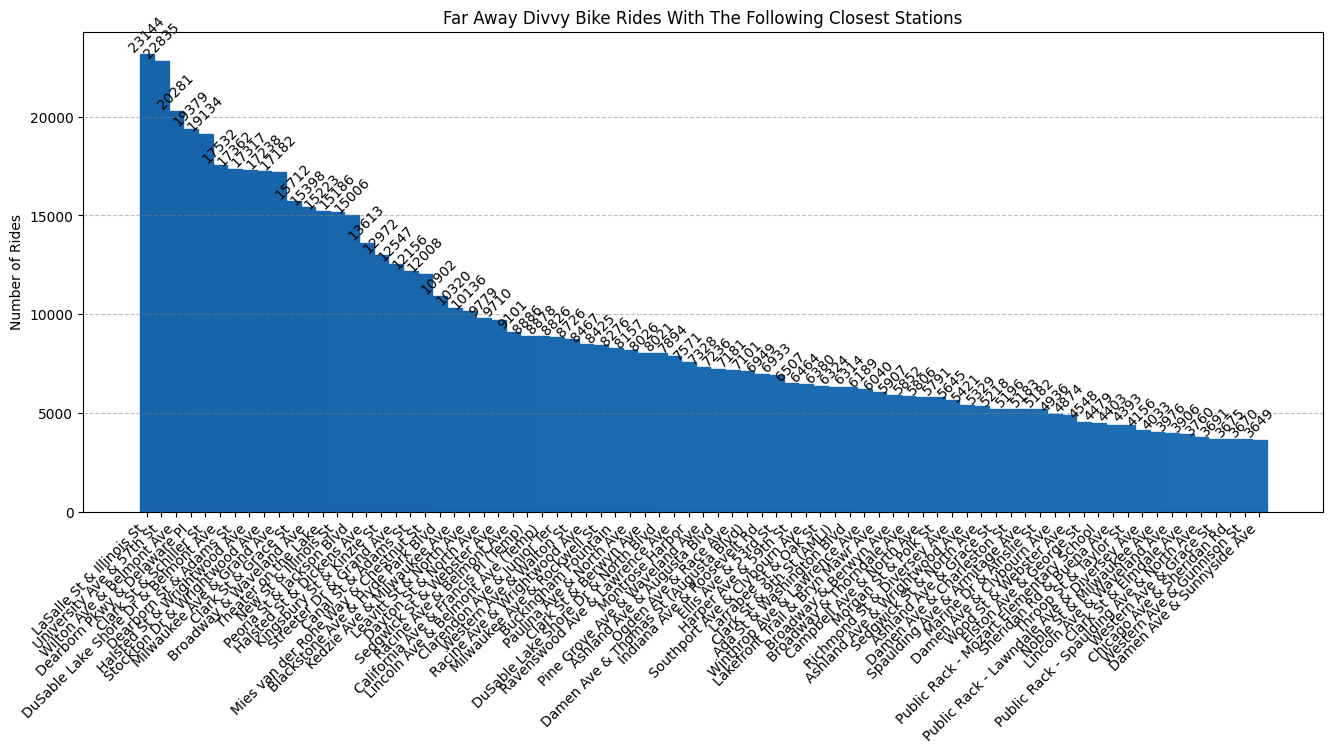

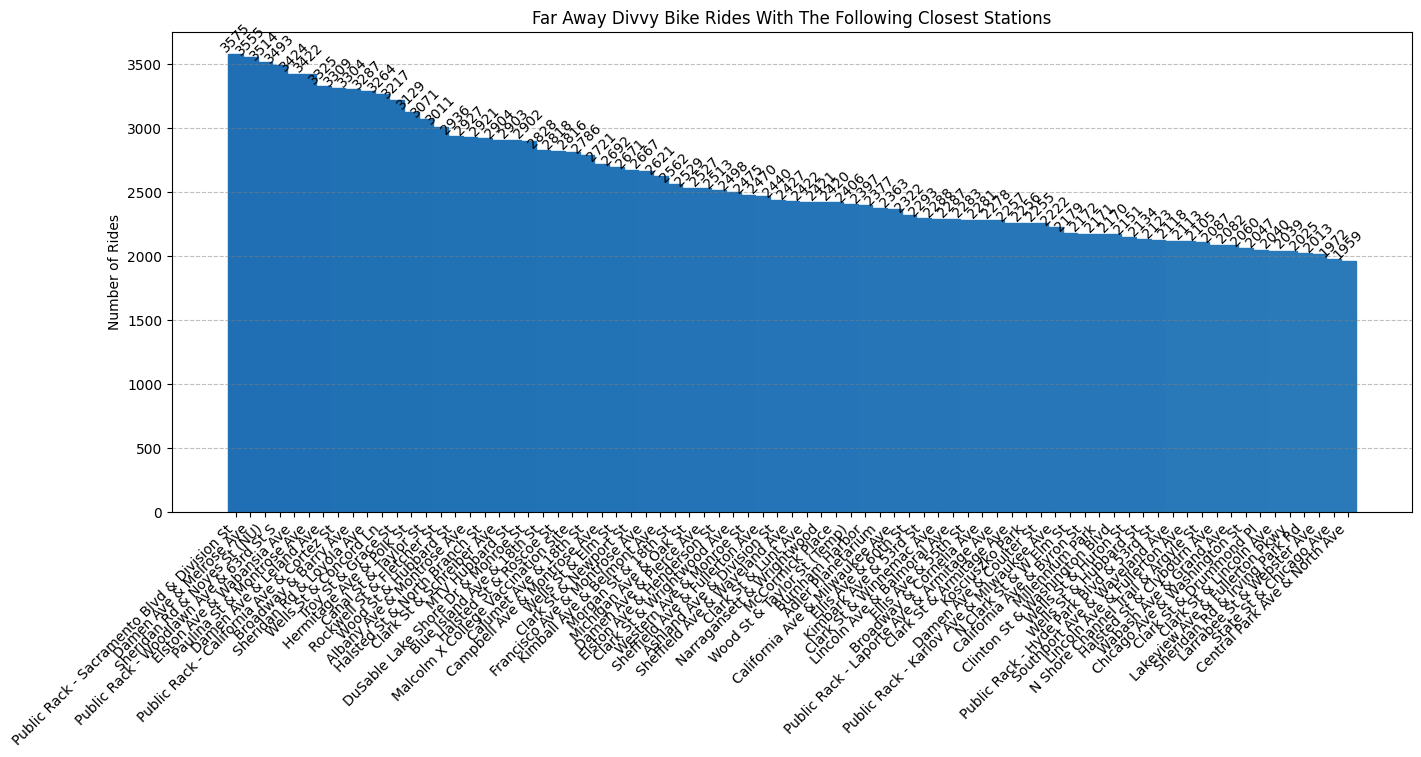

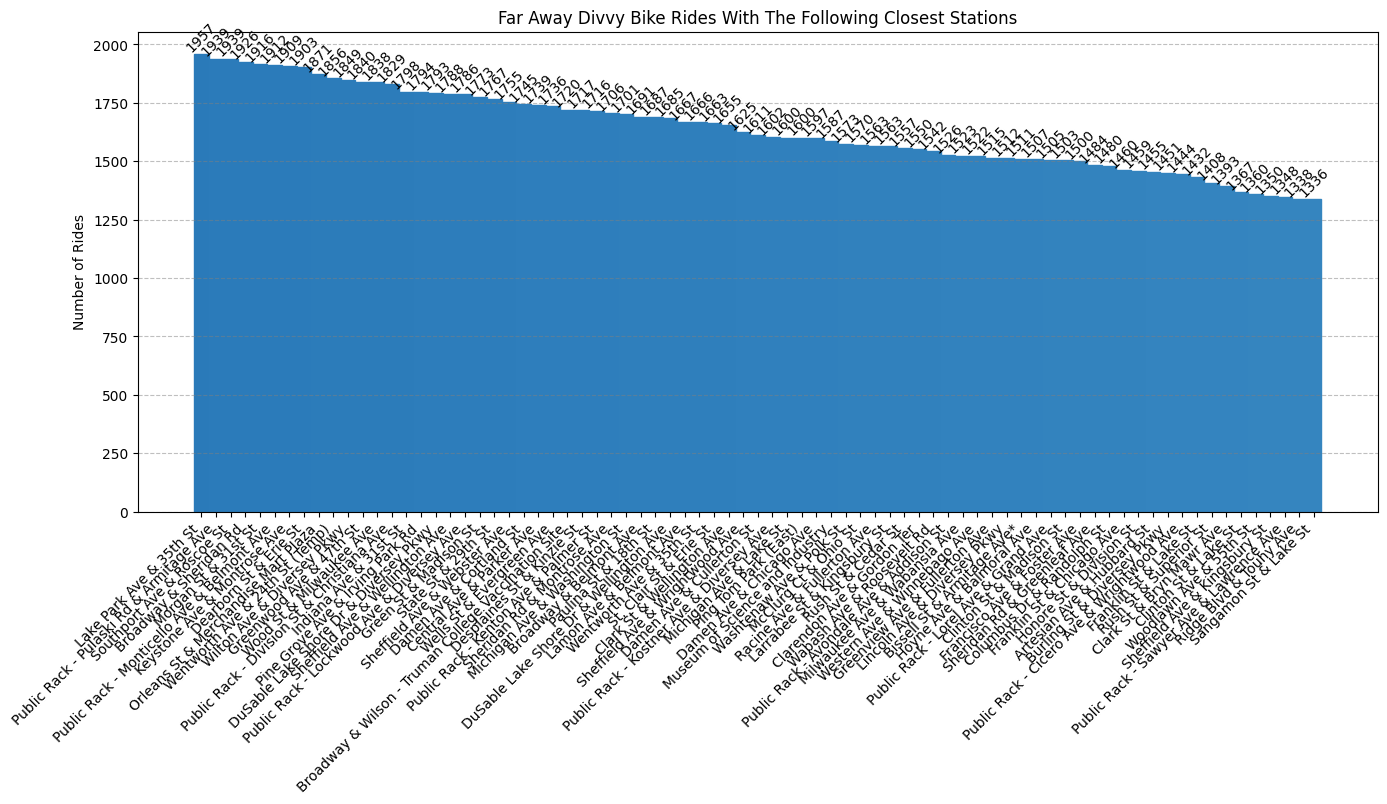

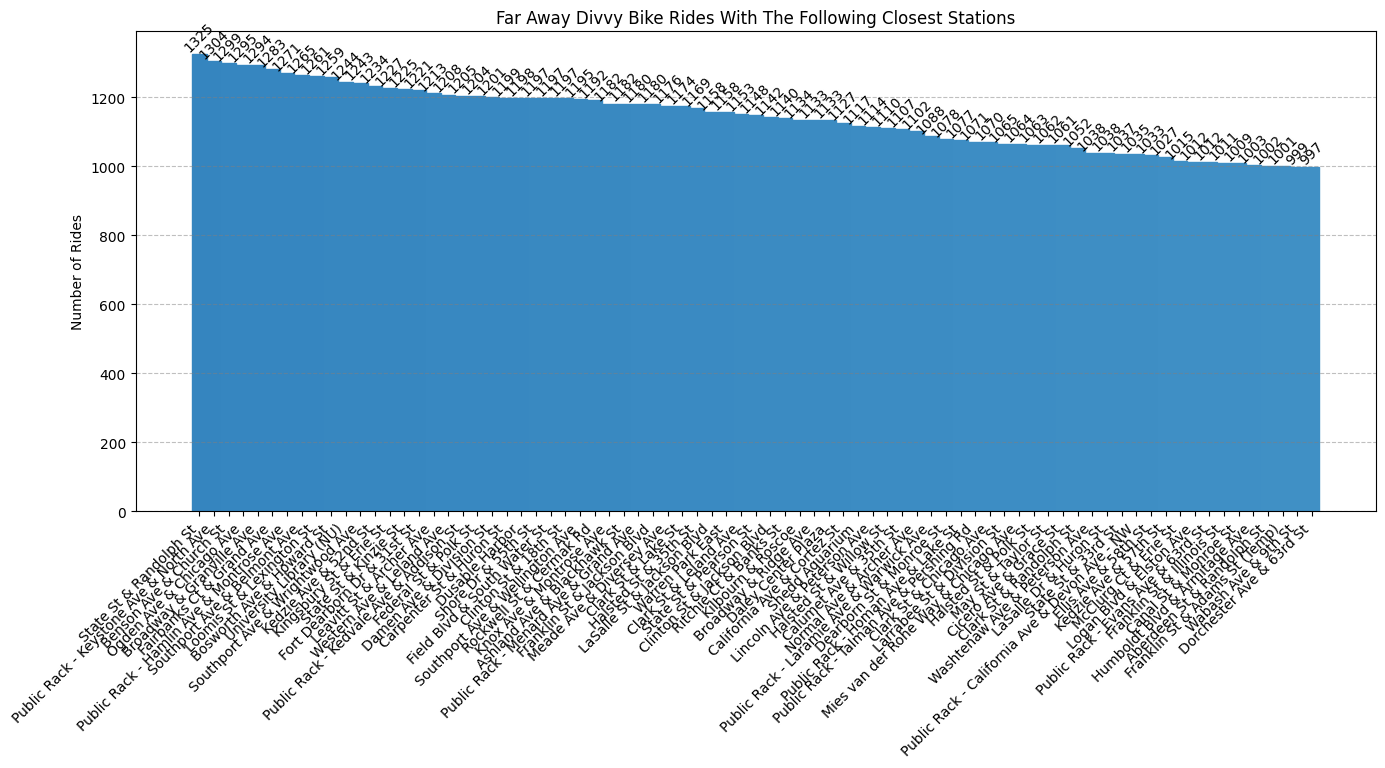

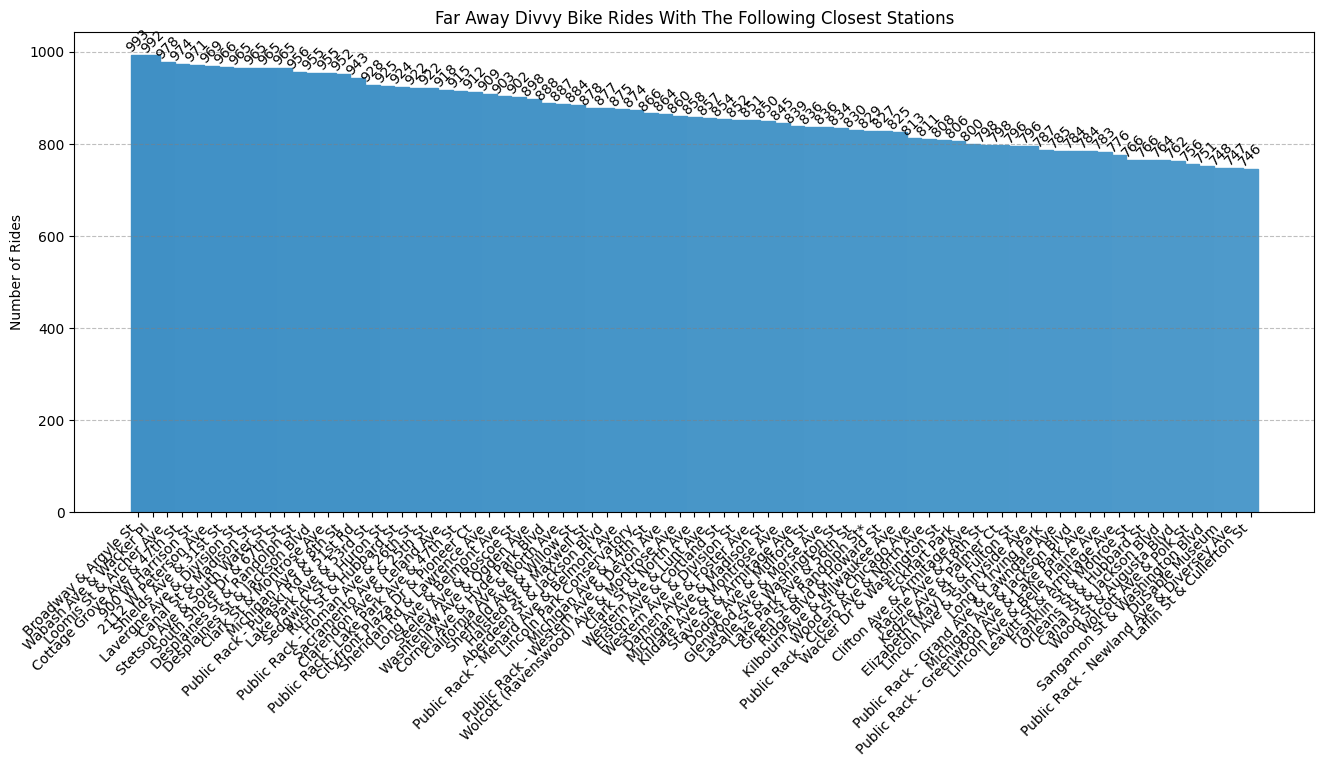

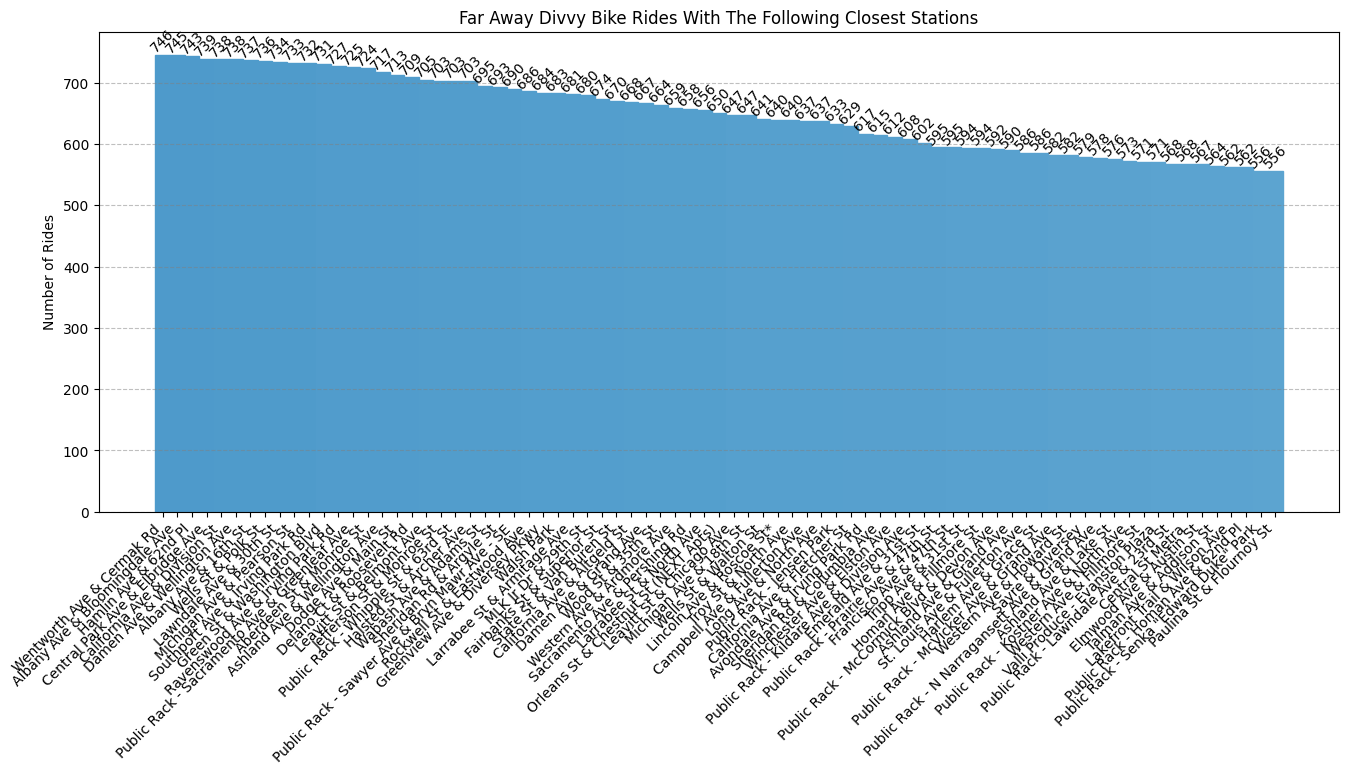

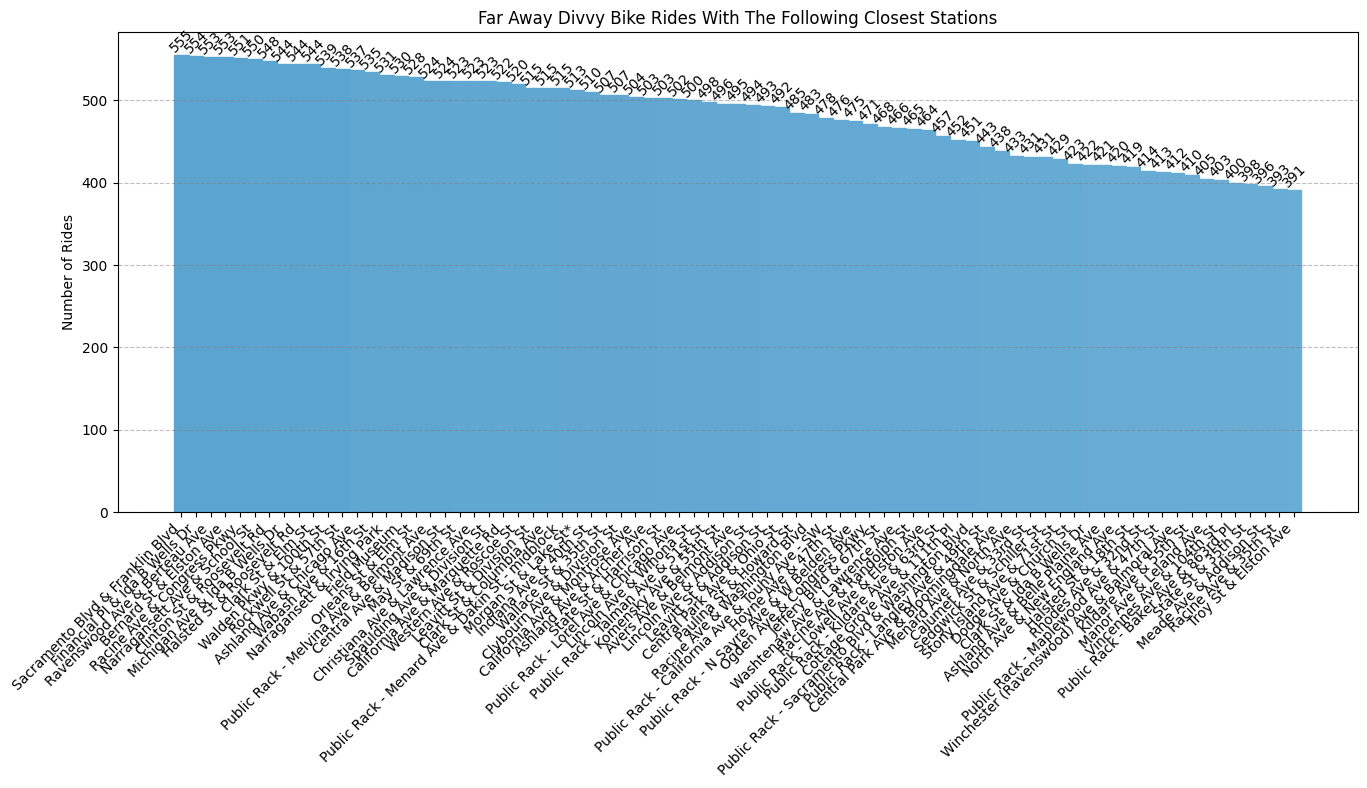

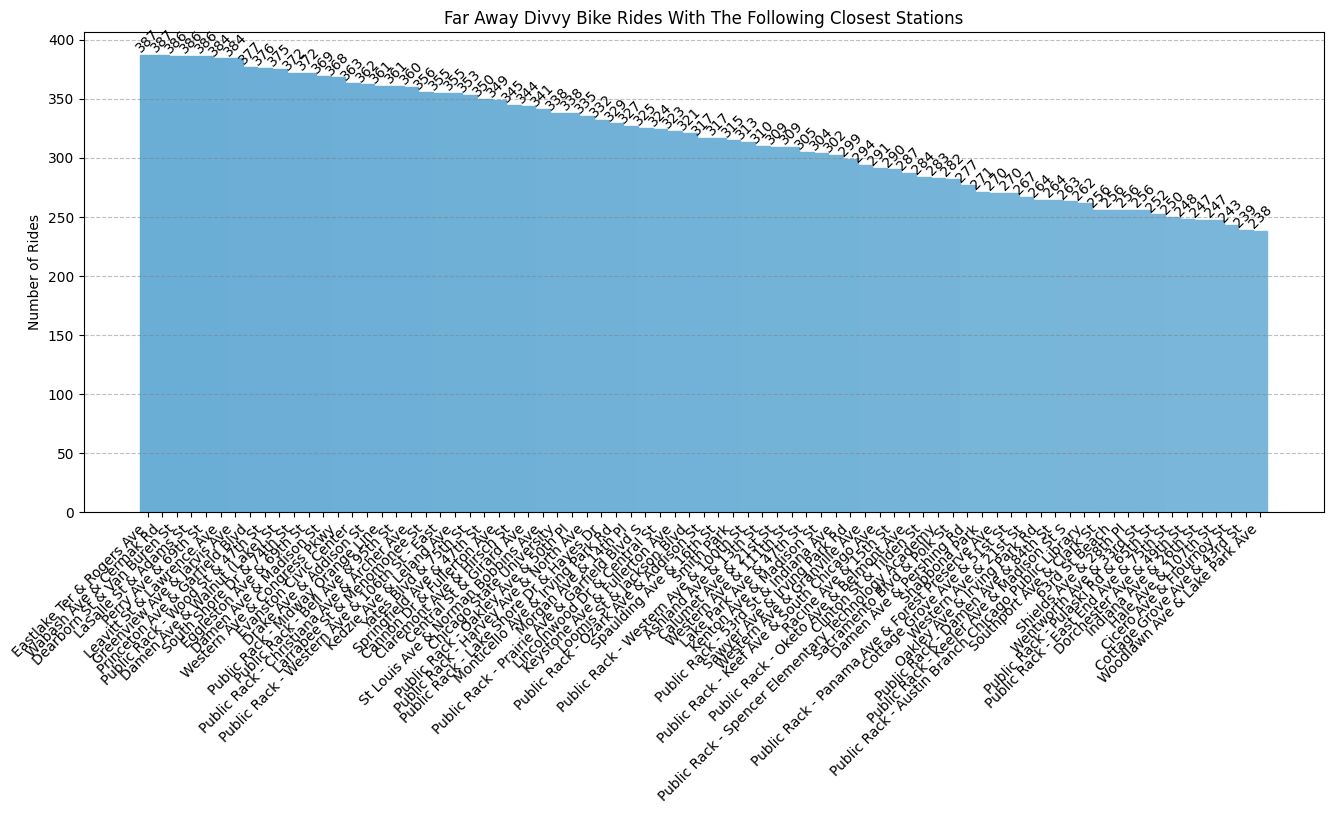

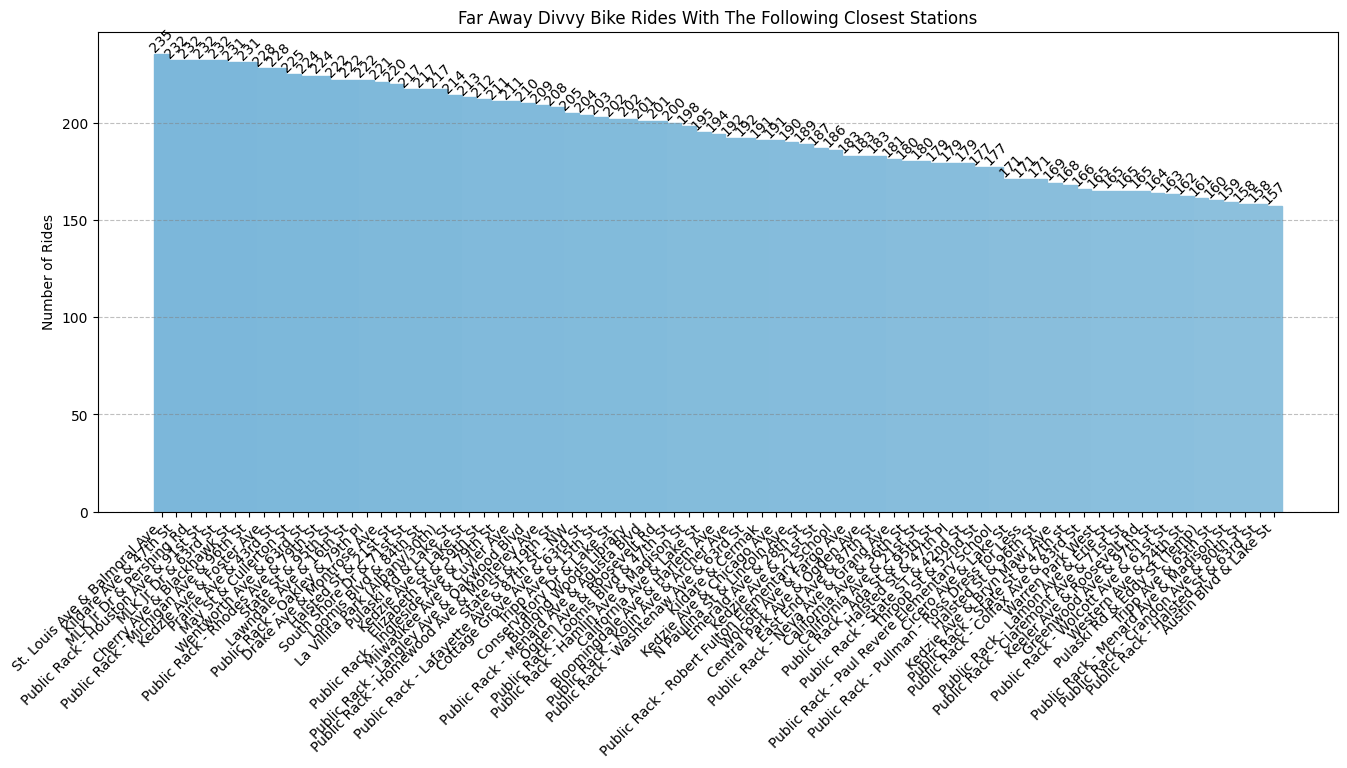

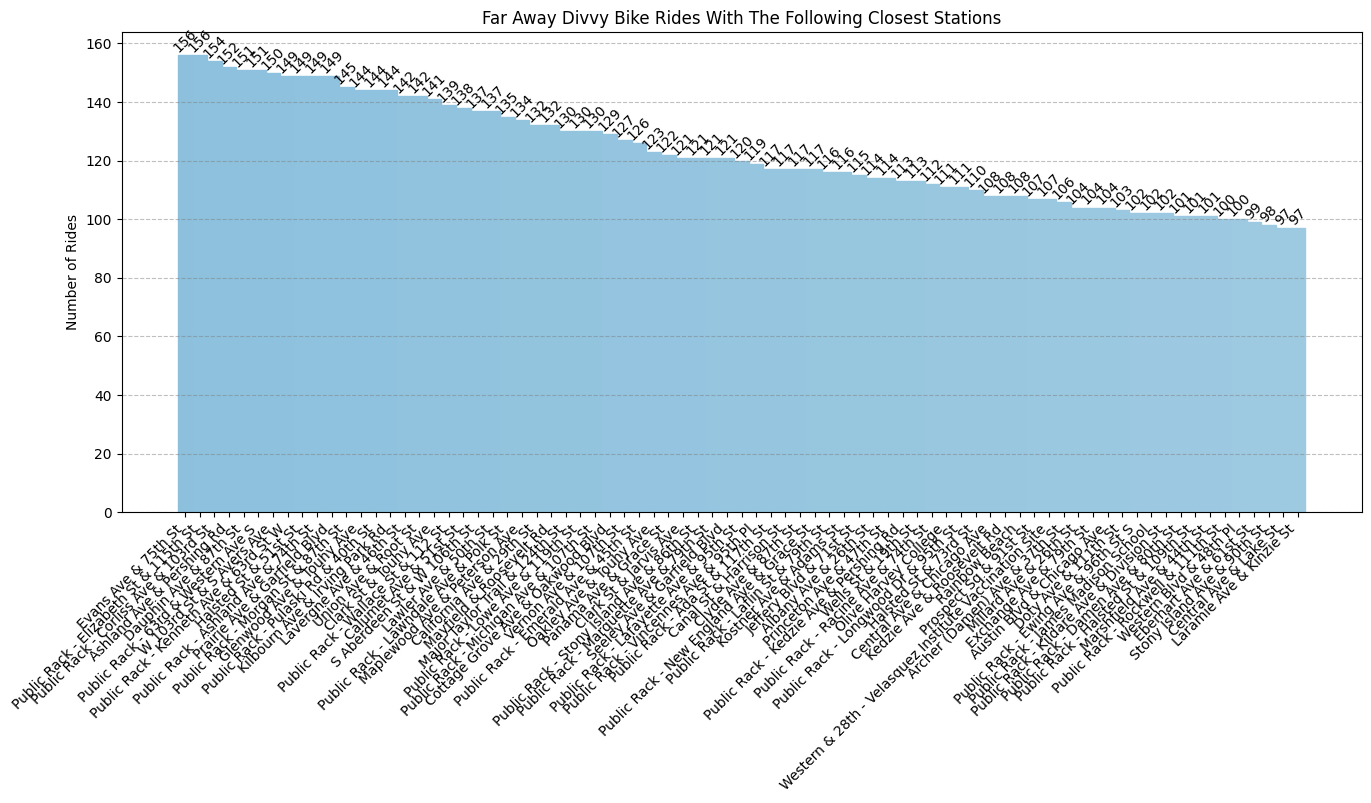

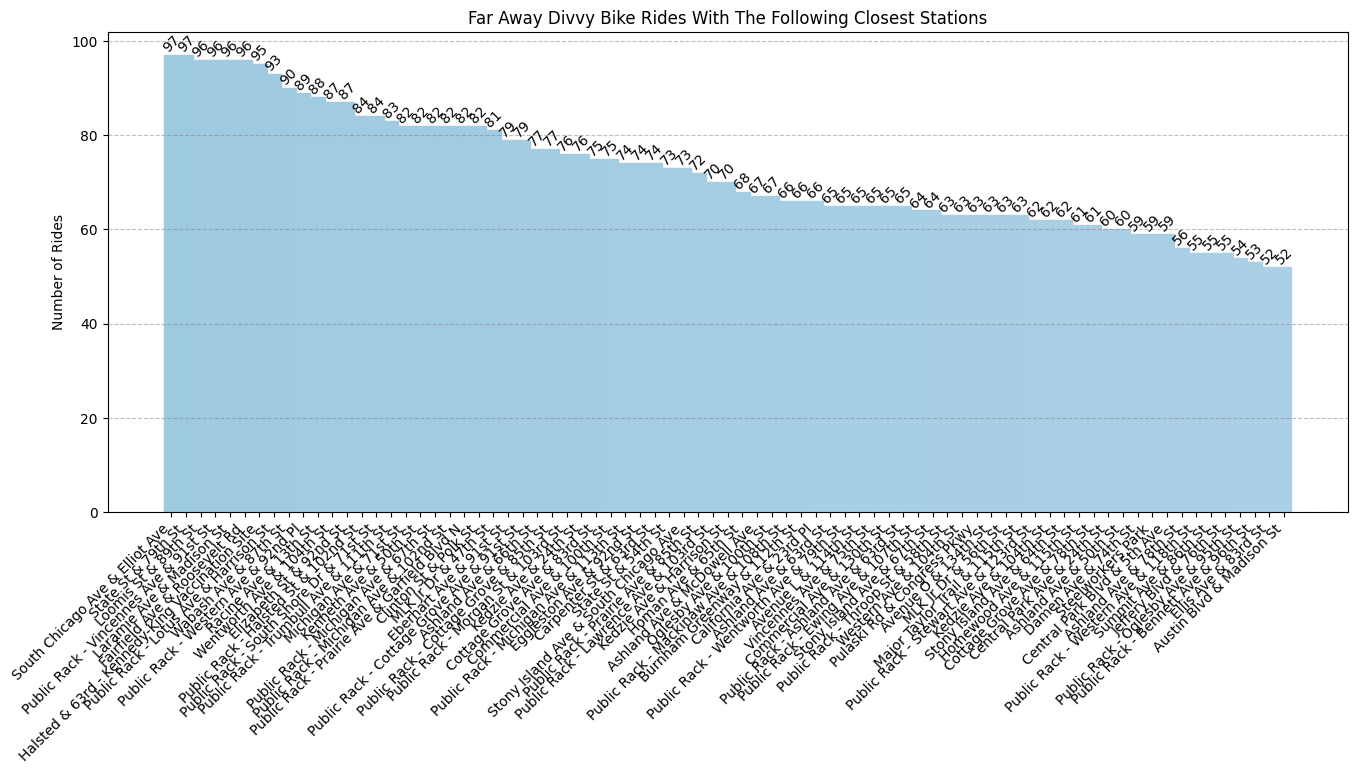

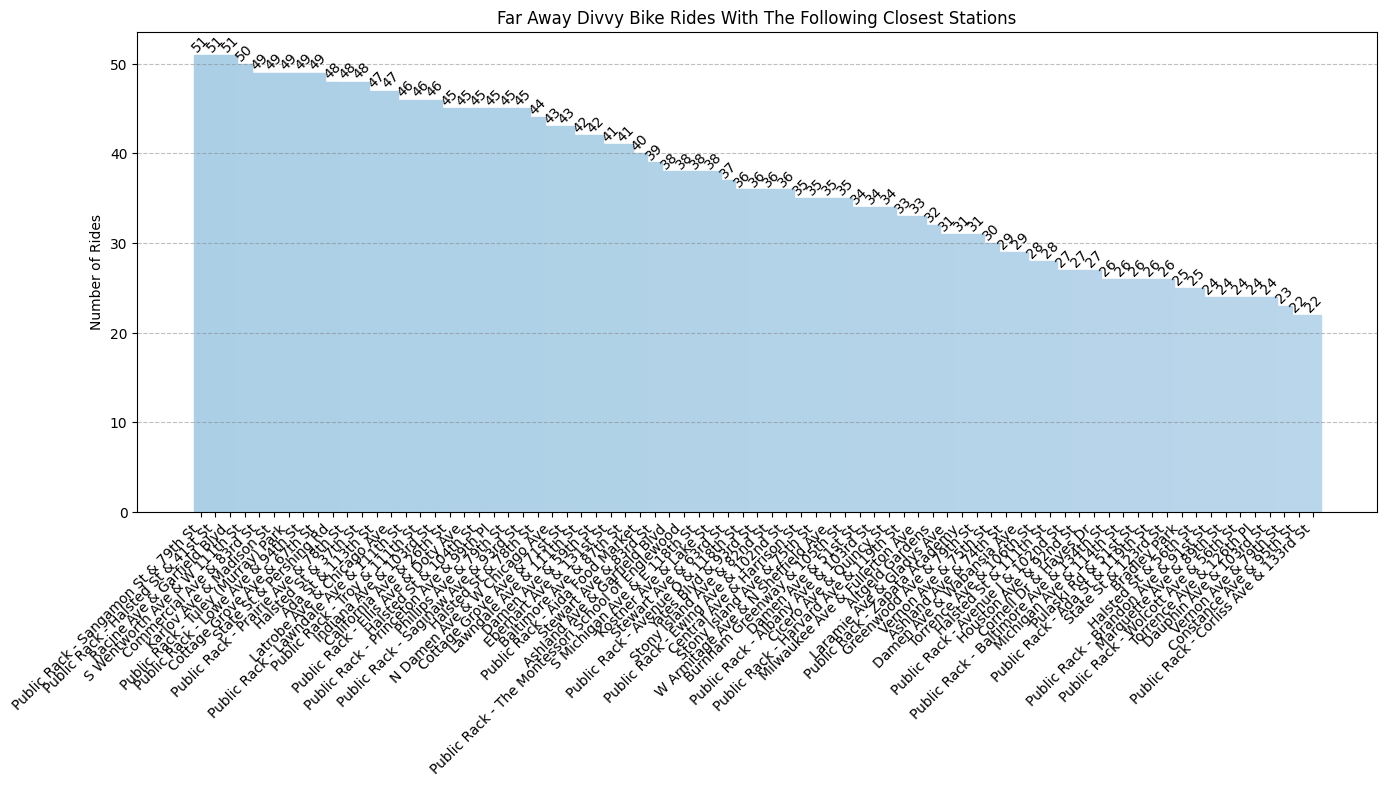

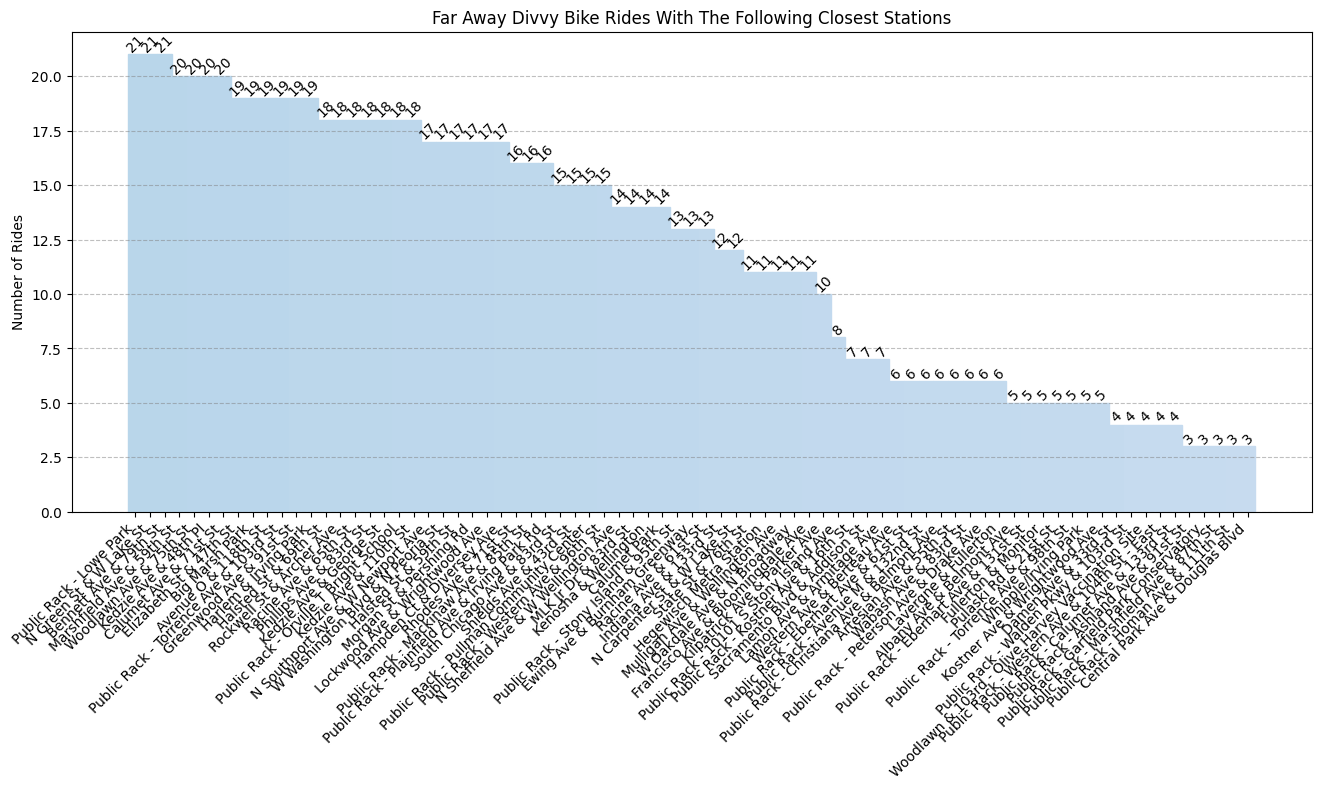

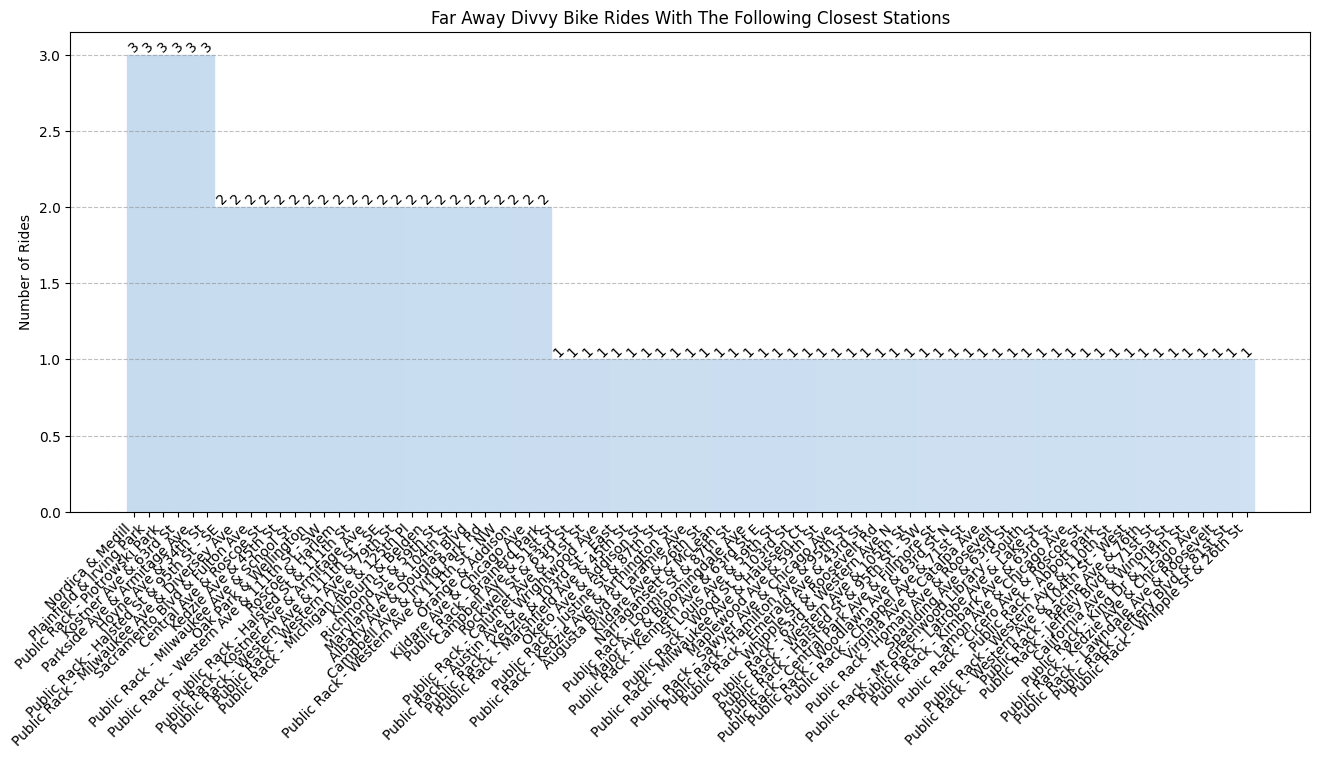

In [18]:
# Read the station_names_not_in_nearest.csv file
df = pd.read_csv('station_names_not_in_nearest.csv')

# Load the bike ride data
bike_ride_data = pd.read_csv('binned_farthest_divvy_location.csv')

# Count the number of rides for each station in station_names_not_in_nearest
rides_count = bike_ride_data['nearest_station_name'].value_counts()

# Sort the stations by the number of rides in descending order
sorted_stations = rides_count.index.tolist()

# Initialize the list to store the counts for each subset
subset_counts = []

# Split the stations into 14 subsets
num_subsets = 14
subset_size = len(sorted_stations) // num_subsets
subsets = [sorted_stations[i * subset_size:(i + 1) * subset_size] for i in range(num_subsets)]

# Define the colors for the bars and names
bar_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(sorted_stations)))
name_colors = ['black', 'saddlebrown'] * (num_subsets // 2 + 1)

# Create separate plots for each subset of stations
for i, subset in enumerate(subsets):
    fig, ax = plt.subplots(figsize=(16, 10))

    # Calculate the starting position for each station in the subset
    x = np.arange(len(subset))

    # Calculate the count for each station in the subset
    subset_station_counts = rides_count.loc[subset].fillna(0)

    # Append the counts to the list of subset counts
    subset_counts.append(subset_station_counts)

    # Create the bar graph with continuous solid bars
    bars = ax.bar(x, subset_station_counts, width=1.0, align='center', color=bar_colors[i * subset_size:(i + 1) * subset_size])

    # Set colors for the column names
    xtick_labels = ax.get_xticklabels()
    for j, label in enumerate(xtick_labels):
        label.set_color(name_colors[(j + i) % num_subsets])

    # Set colors for the bars and station names
    for j, bar in enumerate(bars):
        bar.set_color(bar_colors[i * subset_size + j])

        # Add the ride count as text on top of each bar
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), ha='center',
                va='bottom', rotation=45, color='black')

    # Add spacing between the station names
    ax.set_xticks(x)
    ax.set_xticklabels(subset, rotation=45, ha='right', color='black')

    plt.subplots_adjust(bottom=0.4)

    # Set colors for the grid lines
    ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
    ax.xaxis.grid(False)

    # Set the title and y-axis label
    ax.set_title('Far Away Divvy Bike Rides With The Following Closest Stations')
    ax.set_ylabel('Number of Rides')

plt.show()










<ipython-input-19-9d21deb1b958>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(top_stations)))


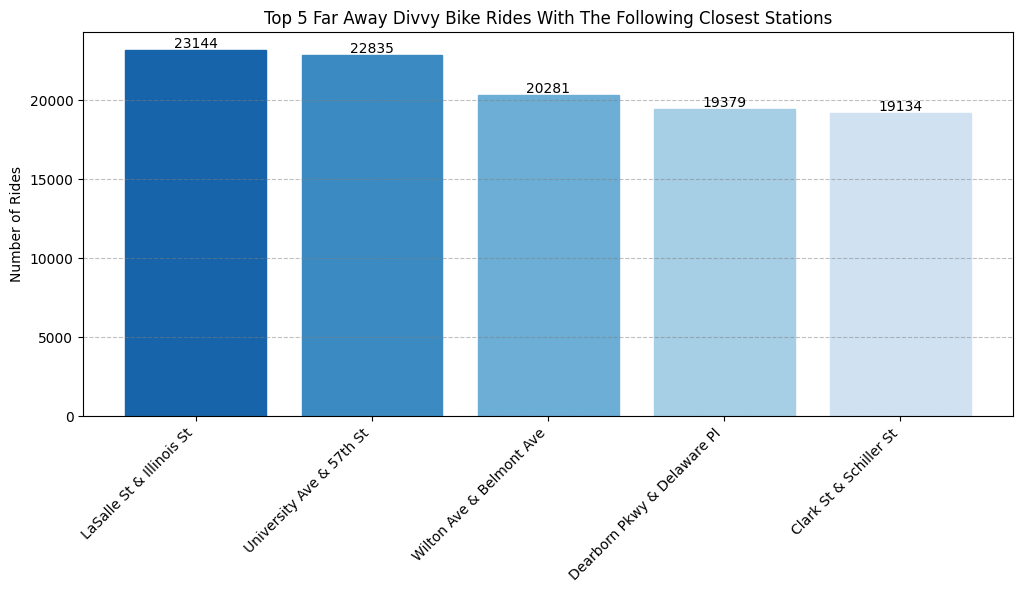

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Read the station_names_not_in_nearest.csv file
df = pd.read_csv('station_names_not_in_nearest.csv')

# Load the bike ride data
bike_ride_data = pd.read_csv('binned_farthest_divvy_location.csv')

# Count the number of rides for each station in station_names_not_in_nearest
rides_count = bike_ride_data['nearest_station_name'].value_counts()

# Sort the stations by the number of rides in descending order
sorted_stations = rides_count.index.tolist()

# Get the top 5 stations
top_stations = sorted_stations[:5]

# Initialize the list to store the counts for each subset
subset_counts = []

# Define the colors for the bars and names
bar_colors = cm.get_cmap('Blues_r')(np.linspace(0.2, 0.8, len(top_stations)))

fig, ax = plt.subplots(figsize=(12, 8))

# Calculate the starting position for each station in the subset
x = np.arange(len(top_stations))

# Calculate the count for each station in the subset
subset_station_counts = rides_count.loc[top_stations].fillna(0)

# Append the counts to the list of subset counts
subset_counts.append(subset_station_counts)

# Create the bar graph with continuous solid bars
bars = ax.bar(x, subset_station_counts, width=0.8, align='center', color=bar_colors)

# Set colors for the bars and station names
for j, bar in enumerate(bars):
    bar.set_color(bar_colors[j])

    # Add the ride count as text on top of each bar
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), ha='center',
            va='bottom', color='black')

# Add spacing between the station names
ax.set_xticks(x)
ax.set_xticklabels(top_stations, rotation=45, ha='right', color='black')  # Rotate station names on the bottom by 45 degrees and make them black

plt.subplots_adjust(bottom=0.4)

# Set colors for the grid lines
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(False)

# Set the title and y-axis label
ax.set_title('Top 5 Far Away Divvy Bike Rides With The Following Closest Stations')
ax.set_ylabel('Number of Rides')

plt.show()




Locations to recommend new Divvy bike stations at as there are rides taking place here without nearby stations

In [20]:
# Read the filtered data with farthest Divvy bike ride locations
df_filtered = pd.read_csv('binned_farthest_divvy_location.csv')

# Get the farthest locations with their coordinates
farthest_locations = df_filtered.loc[df_filtered['nearest_station_distance'] >= df_filtered['nearest_station_distance'].max()]
location_data = farthest_locations[['end_lat', 'end_lng']]

# Apply K-means clustering to find 5 potential station locations
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(location_data)
potential_locations = kmeans.cluster_centers_

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the end station coordinates and count
heatmap_data = farthest_locations[['end_lat', 'end_lng']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the potential station locations
for location in potential_locations:
    lat, lng = location
    folium.Marker(
        location=[lat, lng],
        popup=f"Latitude: {lat}<br>Longitude: {lng}",
        icon=folium.Icon(color='green', icon='star')
    ).add_to(map_divvy)

# Save the location data for the potential station locations
potential_stations = pd.DataFrame(potential_locations, columns=['end_lat', 'end_lng'])
potential_stations.to_csv('potential_stations.csv', index=False)

# Save the map as an HTML file
map_divvy.save('potential_stations_divvy_map.html')

# Display the map
map_divvy



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
